In [27]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
%matplotlib inline

#### Create Data

In [6]:
### Create random blobs
def random_blobs(seed):
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    return X, y

### Create a scatter_plot of points colored by class value
def plot_sample(X,y, classes=3):
    for i in range(classes):
        samples_ix = np.where(y == i)
        plt.scatter(X[samples_ix,0], X[samples_ix, 1])

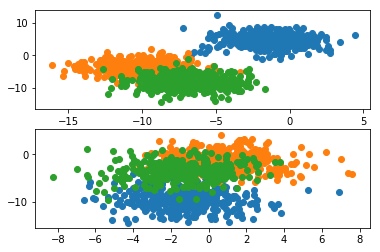

In [7]:
n_problems=2
for i in range(1, n_problems+1):
    plt.subplot(210+i)
    X, y = random_blobs(i)
    plot_sample(X, y)

#### Multilayer Preceptron
This chunk will recreate the random blobs function returning a testing and training set

In [32]:
### Create random blobs and split into testin and training set
def random_blobs(seed):
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    ## one hot encode output variable
    y = to_categorical(y)
    
    ## split into traingin and testing
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

In [33]:
def fit_model(trainX, trainy, testX, testy):
    ## Define Model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    ## Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    ## Return History
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
    return model, history

In [34]:
def summarize_model(model, history, trainX, trainy, testX, testy):
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.legend()

Train: 0.908, Test: 0.926


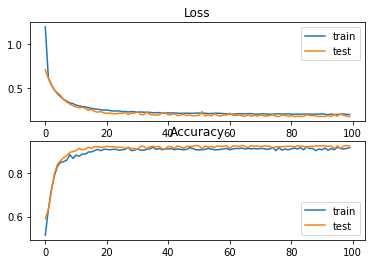

In [35]:
trainX, trainy, testX, testy = random_blobs(1)

# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

summarize_model(model, history, trainX, trainy, testX, testy)

In [36]:
## Save model to file
model.save('model.h5')

Performance of models drop off with seed 2 (Overlapped scatterplot above)

Train: 0.774, Test: 0.810


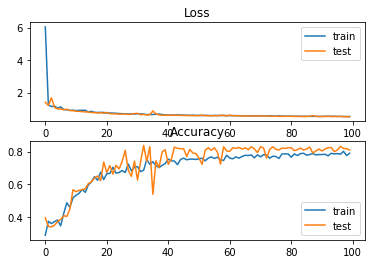

In [21]:
trainX, trainy, testX, testy = random_blobs(2)

# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

summarize_model(model, history, trainX, trainy, testX, testy)

#### Transfer Learning
The weights from model 1 can be the initialization of model 2 to improve performance

In [37]:
## Use loaded model in fit instead of defining layers
def fit_model_t(trainX, trainy, testX, testy):
    model = load_model('model.h5')
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
    return model, history

Train: 0.800, Test: 0.838


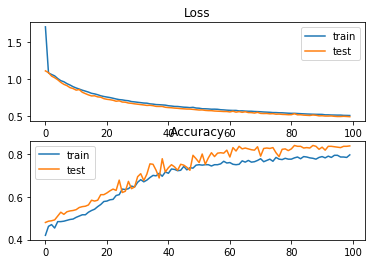

In [38]:
trainX, trainy, testX, testy = random_blobs(2)

# fit model on train dataset
model, history = fit_model_t(trainX, trainy, testX, testy)

summarize_model(model, history, trainX, trainy, testX, testy)

#### Multiple Comparisons to Determine Effect of Transfer Learning

In [41]:
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)
    return model

def eval_standalone_model(trainX, trainy, testX, testy, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        model = fit_model(trainX, trainy)
        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    return scores

def eval_transfer_model(trainX, trainy, testX, testy, n_fixed, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        
        model = load_model('model.h5')
        for i in range(n_fixed):
            model.layers[i].trainable = False
        # define and fit a new model on the train dataset
        # re-compile model
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        model.fit(trainX, trainy, epochs=100, verbose=0)
        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    return scores

Standalone 0.796 (0.068)
Transfer (fixed=0) 0.832 (0.007)
Transfer (fixed=1) 0.823 (0.010)
Transfer (fixed=2) 0.822 (0.008)


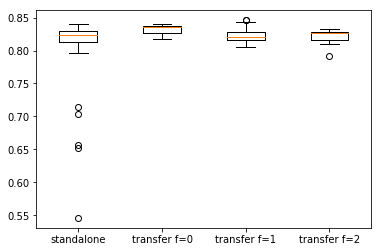

In [45]:
# prepare data for problem 2
trainX, trainy, testX, testy = random_blobs(2)
n_repeats = 30
dists, dist_labels = list(), list()
 
# repeated evaluation of standalone model
standalone_scores = eval_standalone_model(trainX, trainy, testX, testy, n_repeats)
print('Standalone %.3f (%.3f)' % (np.mean(standalone_scores), np.std(standalone_scores)))
dists.append(standalone_scores)
dist_labels.append('standalone')
 
# repeated evaluation of transfer learning model, vary fixed layers
n_fixed = 3
for i in range(n_fixed):
    scores = eval_transfer_model(trainX, trainy, testX, testy, i, n_repeats)
    print('Transfer (fixed=%d) %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))
    dists.append(scores)
    dist_labels.append('transfer f='+str(i))
# box and whisker plot of score distributions
plt.boxplot(dists, labels=dist_labels)
plt.show()